In [1]:
from PIL.Image import BILINEAR
from PIL import Image
import torch
import torchvision
import numpy as np
import pandas as pd
import zipfile
import os
import random
import shutil
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)

In [3]:
# Извлечение из zip
def extract_data(from_path, to_path = "./data"):
    with zipfile.ZipFile(from_path, 'r') as zip:
        zip.extractall(to_path)

# Для поворота всех изображений в train
def make_extra_data(root_path): 
    suffix = ['_90', '_180', '_270']
    angles = [90, 180, 270]

    for path in root_path:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for file_name in files:
            img = Image.open(path + file_name)
            for suf, angle in enumerate(angles):
                new_img = img.rotate(angle = angle, expand = True)
                img_path = path + file_name[:file_name.find('.')] + suffix[suf] + ".jpg"
                if not os.path.exists(img_path):
                    new_img.save(img_path, 'JPEG')
        
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' in x, files))
        print('{} new files in {}'.format(len(files), path))

# Разделение на train и validation
def create_train_val(max_i=5):
    for dir_name in [train_dir, val_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        source_dir = os.path.join(root_path, 'train', class_name)
        
        i = 0
        for _, file_name in enumerate(os.listdir(source_dir)):
            if i % max_i != 0:
                dest_dir = os.path.join(train_dir, class_name)
            else:
                dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
            i += 1
    
    for fold in ['train', 'val']:
        sum = 0
        for class_name in class_names:
            path = os.path.join(fold, class_name)
            files = os.listdir(path)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            sum += len(files)
            
        print('{}  files in {}'.format(sum, fold))


# Создание папки с тестовой выборкой
def create_test():
    src = os.path.join(root_path, 'test')
    out = os.path.join(test_dir, 'unknown')
    if not os.path.exists(out):
        shutil.copytree(src, out)

    files = os.listdir(out)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print("{} files in Test".format(len(files)))

In [4]:
# set_seed(0)

root_path = ".\\data\\plates"
train_dir = "train"
val_dir = 'val'
test_dir = 'test'
class_names = ["cleaned", "dirty"]

extract_data(r'D:\Programming\CNN\Cleaned_vs_Dirty\input\plates.zip')

make_extra_data([
    os.path.join(root_path, train_dir, "cleaned\\"),
    os.path.join(root_path, train_dir, "dirty\\")
])
create_train_val(6)
create_test()


60 new files in .\data\plates\train\cleaned\
60 new files in .\data\plates\train\dirty\
134  files in train
26  files in val
744 files in Test


In [5]:
# Перемешивание RGB каналов в тензоре
class RGBShuffleInTensor(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img_tensor):
        if self.p < random.random():
            return img_tensor
        indices = np.random.permutation(3)
        # print(indices)
        img_tensor[:] = img_tensor[indices]
        return img_tensor

In [6]:
from torchvision import transforms
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.CenterCrop(224),
        # transforms.CenterCrop(260),
        transforms.RandomResizedCrop(224)
    ]),
    # transforms.Resize((224, 224)),
    transforms.RandomChoice([
        transforms.RandomVerticalFlip(),
        # transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30, resample=BILINEAR),
    ]),
    # transforms.ColorJitter(0.25, 0.3, 0, 0.25),
    transforms.RandomPerspective(p = 0.1, distortion_scale=0.1),
    transforms.ToTensor(),
    RGBShuffleInTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

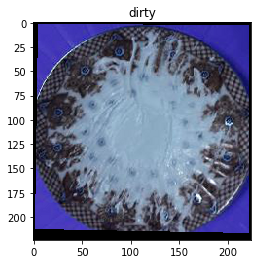

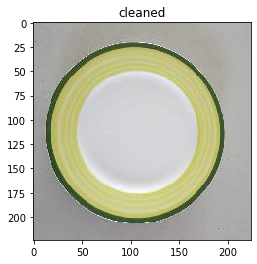

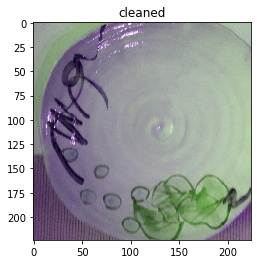

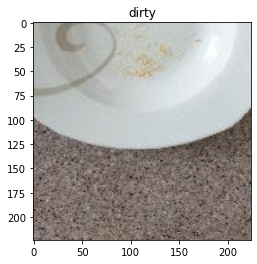

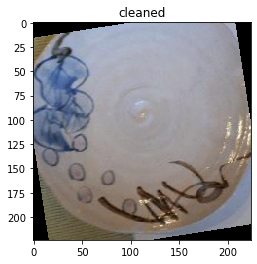

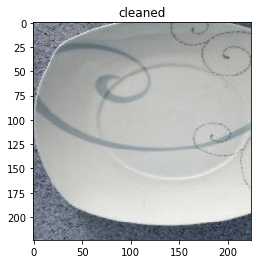

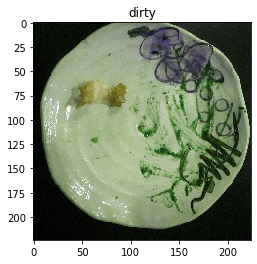

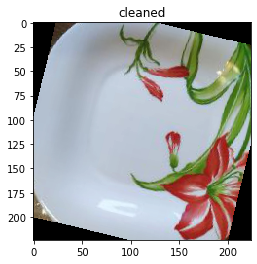

In [29]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = norm_std * image + norm_mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

iterator = iter(train_dataloader)
X_batch, y_batch = next(iterator)
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
acc_history = []
loss_history = []


def train_model(model, loss_func, optimizer, max_epochs = 50, scheduler=None):
    print('Train on {}'.format(device.upper()))

    for epoch in range(max_epochs):
        print("Epoch {}/{}".format(epoch, max_epochs -1))

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                if scheduler is not None:
                    scheduler.step()
                model.train()
            else:
                model.eval()
                dataloader = val_dataloader
            
            running_loss = 0.
            running_acc = 0.

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss = loss_func(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()
                running_acc += (preds_class == labels.data).float().mean()

                del inputs
                del labels
            
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if (phase == 'val'):
                acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)
            
            print('{} Loss: {:.3f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))
            print()
        print()
    return model



In [10]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        # (224, 224)

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            torch.nn.Tanh(),
            torch.nn.BatchNorm2d(8),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        
        #(112, 112)
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.Tanh(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        #(54, 54)
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            torch.nn.Tanh(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #(26, 26)
        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=26*26*256, out_features=256),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=128, out_features=2)
        )


    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc_block(x)
        return x


In [11]:
set_seed(0)

model = MyModel()
model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.7,  lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [12]:
!nvidia-smi

Mon Oct 05 01:40:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.38       Driver Version: 456.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 950M   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |    527MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [13]:
train_model(model, loss_func, optimizer, scheduler=scheduler, max_epochs=100);

Train on CUDA:0
Epoch 0/99
train Loss: 0.829 Acc: 0.593

val Loss: 0.919 Acc: 0.500


Epoch 1/99
train Loss: 0.726 Acc: 0.537

val Loss: 0.791 Acc: 0.500


Epoch 2/99
train Loss: 0.645 Acc: 0.596

val Loss: 0.758 Acc: 0.531


Epoch 3/99
train Loss: 0.610 Acc: 0.701

val Loss: 0.762 Acc: 0.531


Epoch 4/99
train Loss: 0.627 Acc: 0.654

val Loss: 0.745 Acc: 0.531


Epoch 5/99
train Loss: 0.636 Acc: 0.600

val Loss: 0.772 Acc: 0.531


Epoch 6/99
train Loss: 0.630 Acc: 0.642

val Loss: 0.784 Acc: 0.562


Epoch 7/99
train Loss: 0.606 Acc: 0.725

val Loss: 0.856 Acc: 0.562


Epoch 8/99
train Loss: 0.608 Acc: 0.694

val Loss: 0.703 Acc: 0.625


Epoch 9/99
train Loss: 0.596 Acc: 0.696

val Loss: 0.704 Acc: 0.531


Epoch 10/99
train Loss: 0.605 Acc: 0.669

val Loss: 0.646 Acc: 0.656


Epoch 11/99
train Loss: 0.636 Acc: 0.586

val Loss: 0.713 Acc: 0.656


Epoch 12/99
train Loss: 0.599 Acc: 0.703

val Loss: 0.687 Acc: 0.688


Epoch 13/99
train Loss: 0.553 Acc: 0.757

val Loss: 0.674 Acc: 0.656




In [14]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in (test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [16]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df.head()

id     label
0  test\unknown\0000.jpg  0.834508
1  test\unknown\0001.jpg  0.821164
2  test\unknown\0002.jpg  0.179212
3  test\unknown\0003.jpg  0.800807
4  test\unknown\0004.jpg  0.818582

In [17]:
submission_df[submission_df['label'] < 0.5]

id     label
2    test\unknown\0002.jpg  0.179212
12   test\unknown\0012.jpg  0.341409
14   test\unknown\0014.jpg  0.369606
24   test\unknown\0024.jpg  0.355073
26   test\unknown\0026.jpg  0.113102
..                     ...       ...
729  test\unknown\0729.jpg  0.369619
731  test\unknown\0731.jpg  0.257845
732  test\unknown\0732.jpg  0.296205
737  test\unknown\0737.jpg  0.364586
741  test\unknown\0741.jpg  0.293678

[206 rows x 2 columns]

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace(r'test\\unknown\\', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [19]:
submission_df.to_csv('submission_3.csv')

In [20]:
iterator = iter(test_dataloader)

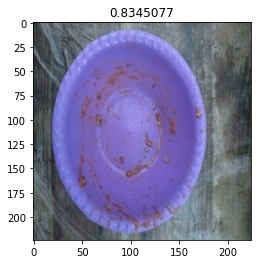

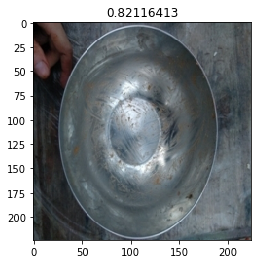

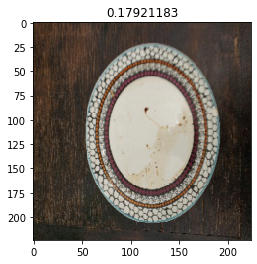

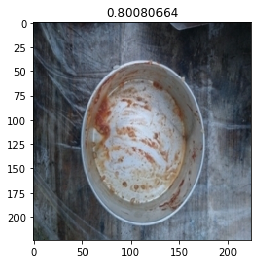

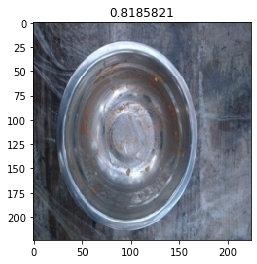

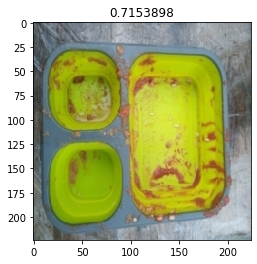

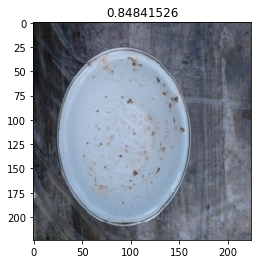

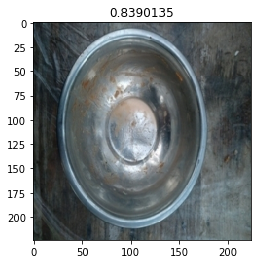

In [21]:
inputs, labels, paths = next(iterator)

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

[&lt;matplotlib.lines.Line2D at 0x2148c324a00&gt;]

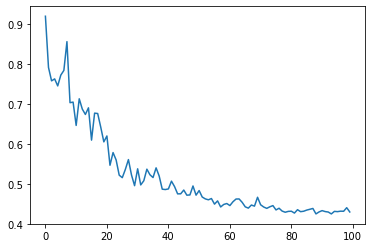

In [22]:
plt.plot(loss_history)

[&lt;matplotlib.lines.Line2D at 0x2148c9242b0&gt;]

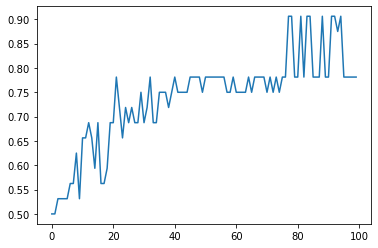

In [23]:
plt.plot(acc_history)

In [25]:
torch.save(model, 'MyBest.pt')

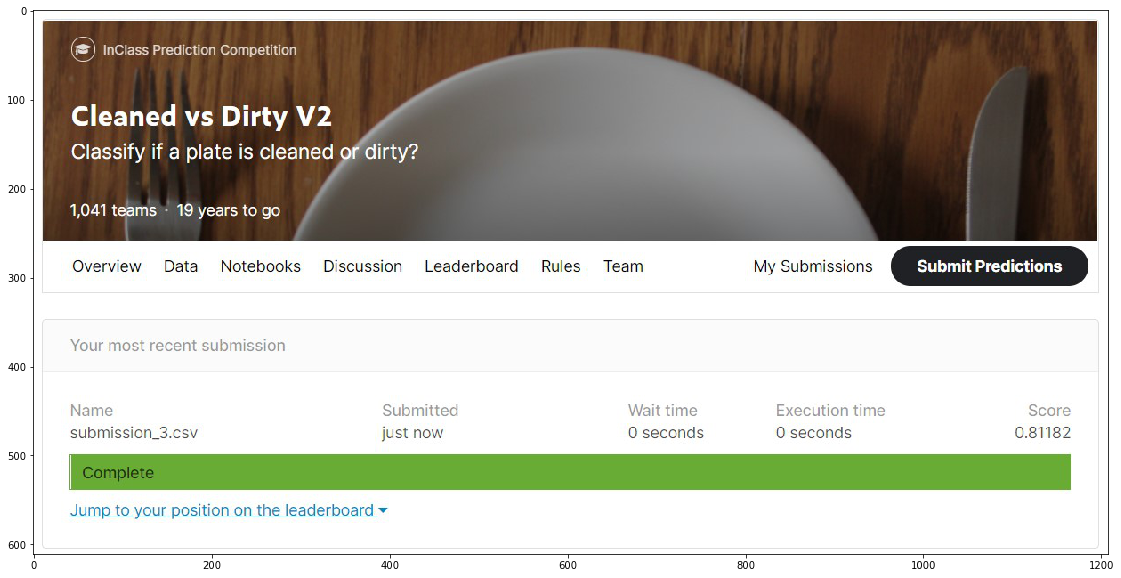

In [28]:
img = Image.open("best_my.jpg")
plt.figure(figsize = (20, 10))
plt.imshow(img)
plt.show()

In [24]:
# 0.81182
# Tanh()
# SGD m7
# batch 8
# epoch 100
# i = 6

## Общие выводы:  
### score - accuracy 
   
transfer-learning лучше показал результат - 0.844 (максимальный, но не зафиксированный - 0,849 - был на больших епохах).  
Добавление в train повернутых картинок на углы 90/180/270 немного ухудшало score.  
Для моей модели это наоборот улучшило результат.    
  
Из идей для модификации модели:  
1. Отделение тарелки от фона / добаление шума для фона  
2. Использовать другой подход к обучению из-за малого размера тренировочных данных